After excluding the bad PCRs, is the remaining data sufficient to predict drug classes?

In [202]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import pathlib
from plotnine import *

from sklearn.metrics import log_loss
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE

from tqdm import tqdm

In [57]:
df = pd.read_csv(pathlib.Path.cwd().joinpath('Analysis','8-Clean_for_ML', 'HypoIII_for_ML_encoded.csv'))

In [58]:
df.head()

,Drug,Conc,Replicate,strain.0,strain.1,strain.10,strain.100,strain.101,strain.102,strain.103,...,strain.91,strain.92,strain.93,strain.94,strain.95,strain.96,strain.97,strain.98,strain.99,Class
0,drug_0,2xMIC,1,0.359612,-0.911401,1.554297,0.069421,-2.972960,1.185445,0.421721,...,0.176432,0.449538,0.131855,-0.794105,1.381503,-0.938048,-2.939168,1.492050,-0.387570,Class 4
1,drug_0,2xMIC,2,0.922680,0.156397,1.587909,0.587814,0.183369,0.565838,1.133654,...,0.702362,0.783339,0.747126,0.113741,1.673887,-0.256643,-0.483839,1.684535,1.228144,Class 4
2,drug_0,2xMIC,3,1.003276,0.171781,1.870643,0.381407,-0.678374,1.030591,1.469478,...,0.911449,0.944320,0.480790,-0.326351,1.691710,0.168192,-0.834700,1.609109,1.397204,Class 4
3,drug_0,2xMIC,4,1.825450,0.914839,1.976140,1.693167,0.974058,2.142402,2.025873,...,1.264043,1.414149,1.483434,0.833600,2.156906,1.275261,1.326924,2.090184,1.211598,Class 4
4,drug_0,2xMIC,5,1.862371,0.871132,1.937450,1.371979,0.936343,1.996058,2.160803,...,1.460437,1.147487,1.533885,1.618346,2.086125,0.782927,0.709278,2.169011,1.499092,Class 4


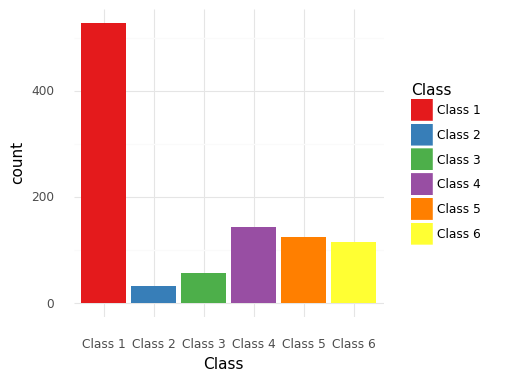

<ggplot: (-9223371915744484678)>

In [139]:
(ggplot(df, aes(x='Class', fill='Class'))
 +geom_bar()
 +theme_minimal()
 +theme(figure_size=(4,4))
 +scale_fill_brewer(type='qual', palette='Set1'))

In [60]:
df = df[~df['Class'].isna()]
df = df.sort_values(by=['Class', 'Drug']).reset_index()

In [61]:
#df of drugs with their class
drug_class = df[['Drug', 'Class']].drop_duplicates()
drug_class.head()

,Drug,Class
0,drug_12,Class 1
17,drug_13,Class 1
21,drug_14,Class 1
32,drug_2,Class 1
46,drug_20,Class 1


### Logistic Regression

First we will implement a logistic regression model with a lasso coefficient. Other changes we make are:
- Split data into training and validation using LeaveOneGroupOut. Each group is a drug. This allows us to mimic a test situation where we obtain a drug with an unknown mechanism of action    
- Use lasso regularization
- Use SMOTE (Synthetic Minority Over-sampling TEchnique) to correct for class imbalance

First we will iterate over a number of regularization strengths

In [8]:
def logistic_reg_vanilla(df: pd.DataFrame, C: float) -> float:
    """
    Fits a logistic regression model using leave out group out for validation and SMOTE for oversampling. Returns cross entropy loss
    """
    X = df.filter(regex=('\.')).values
    y = df['Class'].values
    groups = df['Drug'].values
    n_classes = df['Class'].nunique()
    predictions = np.full([len(y), n_classes], np.nan)
    logo = LeaveOneGroupOut()
    for train_ind, test_ind in logo.split(X, y, groups):
        X_train, y_train= SMOTE().fit_sample(X[train_ind], y[train_ind])
        X_test, y_test = X[test_ind], y[test_ind]   
        model = LogisticRegression(penalty='l1', C=C, solver='liblinear', multi_class='ovr')
        model.fit(X_train, y_train)
        predictions[test_ind] = model.predict_proba(X_test)
    ce = log_loss(y, predictions)
    return ce
        
        

In [27]:
output_metrics = {}
for C in [0.01, 0.1, 1, 10, 100]:
    output_metrics[C] = logistic_reg_vanilla(df, C)
    print(f'C : {C}, cross-entropy: {output_metrics[C]}')

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

C : 0.01, cross-entropy: 1.2805306723809062


 20%|████████████████▊                                                                   | 1/5 [01:39<06:36, 99.09s/it]

C : 0.1, cross-entropy: 0.8427116188611455


 40%|█████████████████████████████████▏                                                 | 2/5 [04:29<06:01, 120.54s/it]

C : 1, cross-entropy: 0.9831816082805978


 60%|█████████████████████████████████████████████████▊                                 | 3/5 [08:45<05:21, 160.98s/it]

C : 10, cross-entropy: 1.0055688717317086


 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [11:58<02:50, 170.87s/it]

C : 100, cross-entropy: 1.18687016395269


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [14:33<00:00, 165.82s/it]


The C of 0.1 seems to give the best results, hence we will use it for the next step

In [158]:
def logistic_reg(df: pd.DataFrame, C: float):
    """
    Adapts logisitic_reg_vanilla to output feature importances and predictions. The importances are averaged over each LOGO iteration.
    """
    X = df.filter(regex=('\.')).values
    y = df['Class'].values
    groups = df['Drug'].values
    n_classes = df['Class'].nunique()
    predictions = np.full([len(y), n_classes], np.nan)
    logo = LeaveOneGroupOut()
    feature_importances  = np.zeros([n_classes, X.shape[1]])
    for train_ind, test_ind in logo.split(X, y, groups):
        X_train, y_train= SMOTE().fit_sample(X[train_ind], y[train_ind])
        X_test, y_test = X[test_ind], y[test_ind]   
        model = LogisticRegression(penalty='l1', C=C, solver='liblinear', multi_class='ovr')
        model.fit(X_train, y_train)
        predictions[test_ind] = model.predict_proba(X_test)
        feature_importances += model.coef_
        
    #format predictions and feature importances before output
    predictions = pd.DataFrame(predictions, columns= model.classes_)
    predictions = predictions.merge(df[['Drug', 'Class']], left_index=True, right_index=True)
    feature_importances = np.abs(feature_importances.T)
    feature_importances = feature_importances/len(groups)
    feature_importances = pd.DataFrame(feature_importances, columns = model.classes_)
    feature_importances['Strain'] = df.filter(regex=('\.')).columns
    feature_importances = feature_importances[['Strain']+list(model.classes_)]
    return predictions, feature_importances
    

In [192]:
predictions, feature_importances = logistic_reg(df, C=0.1)

In [193]:
feature_importances.head()

,Strain,Class 1,Class 2,Class 3,Class 4,Class 5,Class 6
0,strain.0,0.006511,0.0,0.000000,0.0,0.0,0.000000
1,strain.1,0.000000,0.0,0.000000,0.0,0.0,0.000000
2,strain.10,0.000000,0.0,0.000000,0.0,0.0,0.019763
3,strain.100,0.000000,0.0,0.000000,0.0,0.0,0.000000
4,strain.101,0.000000,0.0,0.000003,0.0,0.0,0.022455


In [194]:
feature_importances_ranked = pd.DataFrame({'rank': range(feature_importances.shape[0])})
feature_importances_ranked[class_names] = feature_importances[class_names].apply(lambda col: col.sort_values(ascending=False).values, axis=0)
feature_importances_ranked = feature_importances_ranked.melt(id_vars = 'rank', value_name='feature_importance', var_name='Class')
feature_importances_ranked.head()

,rank,Class,feature_importance
0,0,Class 1,0.110939
1,1,Class 1,0.090653
2,2,Class 1,0.075488
3,3,Class 1,0.070808
4,4,Class 1,0.069415


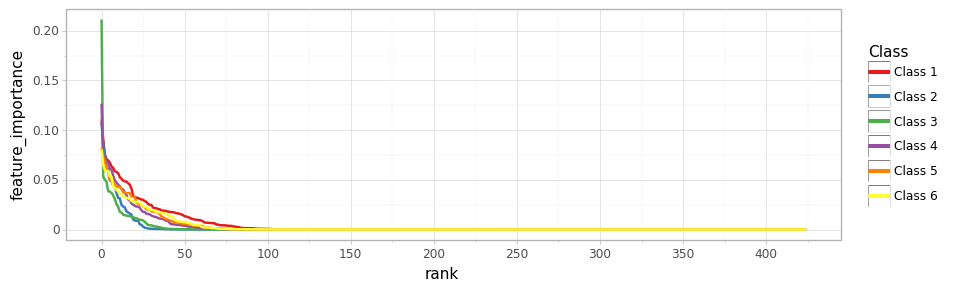

<ggplot: (121113511751)>

In [195]:
(ggplot(feature_importances_ranked, aes(x='rank', y='feature_importance', color='Class'))
+geom_line(size=1.0)
+theme_light()
+theme(figure_size=(10,3))
+scale_x_continuous(breaks=list(range(0,451, 50)))
+scale_color_brewer(type='qual', palette='Set1'))

In [196]:
def extract_useful_features(col, n):
    largest = col.nlargest(n)
    largest = largest[largest!=0]
    return largest.index.to_list()    

In [197]:
feature_importances = feature_importances.set_index('Strain')
minimal_features = list(set(feature_importances[class_names].apply(extract_useful_features, args=(75,)).sum()))
print(len(minimal_features))

227

In [199]:
#create df with minimal_features
feature_importances = feature_importances.reset_index()
feature_importances_filt = feature_importances[feature_importances['Strain'].isin(minimal_features)]
feature_importances_filt['total_importance'] = feature_importances_filt[class_names].sum(axis=1)

In [220]:
#make 'Strain' a categorical column for ggplot
strains_sorted = feature_importances_filt.sort_values(by='total_importance', ascending=False)['Strain'].values
feature_importances_filt['Strain'] = pd.Categorical(feature_importances_filt['Strain'], strains_sorted, ordered=True)

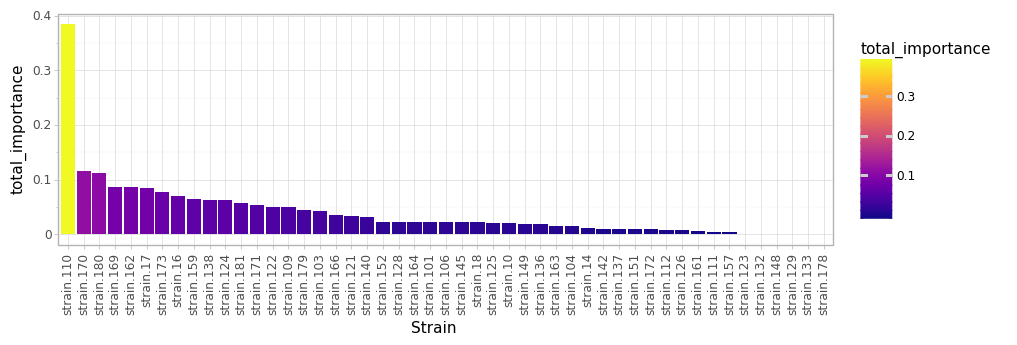

<ggplot: (121115314671)>

In [229]:
(ggplot(feature_importances_filt.iloc[1:50, :], aes(x='Strain', y='total_importance', fill='total_importance'))
+geom_col()
+theme_light()
+theme(figure_size=(10,3), axis_text_x=element_text(angle=90))
+scale_fill_cmap(name='plasma')
)